### imports

In [152]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

from sklearn.feature_selection import SelectKBest
from tensorflow.keras.layers import LeakyReLU

### data preprocessing

In [106]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/10k_data_cleaned.csv')

In [107]:
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,9999,9999,16,Sc5 Ge3,Sc5Ge3,323.046561,"{'crystal_system': 'Hexagonal', 'symbol': 'P6_...",mp-17190,"{'@module': 'pymatgen.core.structure', '@class...",-0.909267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1813,1813,8,Pu1 Ga1,PuGa,175.327444,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-29635,"{'@module': 'pymatgen.core.structure', '@class...",-0.561873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1814,1814,3,Kr1 F2,KrF2,54.722214,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-30009,"{'@module': 'pymatgen.core.structure', '@class...",-0.009234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1816,1816,42,Sr11 Bi10,Sr11Bi10,1548.061711,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-30305,"{'@module': 'pymatgen.core.structure', '@class...",-1.009788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1817,1817,3,Er1 Ag2,ErAg2,61.740049,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-30339,"{'@module': 'pymatgen.core.structure', '@class...",-0.325917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
unwanted_columns = ["builder_meta", "formula_anonymous", "property_name", "deprecated", 
                    "deprecated_reason", "last_updated", "last_updated_by", "origins", "warnings", "task_ids", "uncorrected_energy_per_atom", "is_stable", "is_metal", 
                    "equilibrum_reaction_energy_per_atom", "decomposes_to", "xas", "es_source_calc_id", "dos", "bandstructure", "dos_energy_up", "dos_energy_down",
                    "is_magnetic", "ordering", "total_magnetization", "total_magnetization_normalized_vol", "total_magnetization_normalized_formula_units", "num_magnetic_sites", 
                    "num_unique_magnetic_sites", "types_of_magnetic_species", "universal_anisotropy", "homogenous_poisson", "e_total", "e_ionic", "e_elctronic", "n", "e_ij_max", 
                    "weightded_sace_energy_EV_PER_ANG2", "weighted_surface_energy", "weighted_work_function","surface_anisotropy", "shape_factor", "has_reconstructed",
                     "possible_species", "has_props", "theoretical", "database_IDs", "fields_not_requested"]
# Remove unwanted columns
df_mp = df_mp.drop(columns=unwanted_columns, errors='ignore')

df_mp = df_mp.drop(columns=["deprecation_reasons","equilibrum_reaction_energy_per_atom", "deprecation_reasons", "equilibrum_reaction_energy_per_atom", "grain_boundaries", 
                            "cbm", "vbm", "efermi", "is_gap_direct", "homogenous_poisson", "e_electronic", "weighted_surface_energy_EV_PER_ANG2", "shear_modulus", "bulk_modulus"], errors='ignore')

df_mp.drop(columns=["shear_modulus", "bulk_modulus"], inplace=True, errors='ignore')

In [109]:
#If there are two same elements in the composition, drop one with higher energy above hull

def drop_duplicate_elements(df):
    # Group by 'composition' and keep the one with the lowest 'energy_above_hull'
    df = df.sort_values(by="energy_above_hull")
    df = df.drop_duplicates(subset=["composition"], keep='first')
    return df

df_mp = drop_duplicate_elements(df_mp)
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,9999,9999,16,Sc5 Ge3,Sc5Ge3,323.046561,"{'crystal_system': 'Hexagonal', 'symbol': 'P6_...",mp-17190,"{'@module': 'pymatgen.core.structure', '@class...",-0.909267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273,8745,8745,34,Ga7 Te10,Ga7Te10,1106.871637,"{'crystal_system': 'Trigonal', 'symbol': 'R32'...",mp-18388,"{'@module': 'pymatgen.core.structure', '@class...",-0.410190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1272,8666,8666,6,Hg1 Se1,HgSe,167.628586,"{'crystal_system': 'Trigonal', 'symbol': 'P3_2...",mp-1018722,"{'@module': 'pymatgen.core.structure', '@class...",-0.236921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1271,9283,9283,2,Mo1 C1,MoC,20.711816,"{'crystal_system': 'Hexagonal', 'symbol': 'P-6...",mp-2305,"{'@module': 'pymatgen.core.structure', '@class...",-0.160418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1270,9280,9280,2,Mo1 P1,MoP,28.837101,"{'crystal_system': 'Hexagonal', 'symbol': 'P-6...",mp-219,"{'@module': 'pymatgen.core.structure', '@class...",-0.696002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
def get_rid_of_singular_elements(df):
    # Filter out rows where 'composition' contains only one element

    for element in df["composition"]:
        if isinstance(element, str) and " " in element:
            # If the composition is a string with multiple elements, keep it
            continue
        else:
            # If the composition is a single element, drop the row
            df = df[df["composition"] != element]   
    return df

df_mp = get_rid_of_singular_elements(df_mp)
    

In [111]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

print(len(y))

print(y)


921
1273    0.5754
1272    1.0432
1276    0.8223
1303    4.3683
1297    5.9261
         ...  
5760    2.8504
5769    1.7542
5785    0.2822
5791    0.3639
5796    0.2028
Name: band_gap, Length: 921, dtype: float64


In [112]:
"""
# Define and clean inputs
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

#
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 4: Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Step 5: Feature selection AFTER scaling
#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)

# Step 6: Train-test split on selected features and aligned y
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)
"""

'\n# Define and clean inputs\ny = df_mp[\'band_gap\'].values\nexcluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]\nX = df_mp.drop(columns=excluded + ["band_gap"], errors=\'ignore\')\n\n#\noriginal_indices = df_mp.index.to_numpy()\nformulas = df_mp.loc[original_indices, "formula_pretty"].values\n\n# Step 4: Feature scaling\n#scaler = StandardScaler()\n#X_scaled = scaler.fit_transform(X)\n\n# Step 5: Feature selection AFTER scaling\n#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)\n\n# Step 6: Train-test split on selected features and aligned y\nX_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(\n    X, y, original_indices, test_size=0.2, random_state=42\n)\n'

In [ ]:
# Step 1: Extract target and drop metadata columns
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)



# Keep track of indices and formulas (optional, for post-analysis)
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values


# --- Train / test split first --------------------------------
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

pca = PCA(n_components=10)


X_pca = pca.fit_transform(X)
#build pipeline to avoid leakage
pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('pca',    PCA(n_components=10))
])

X_train_scaled = pipe.fit_transform(X_train)   # fit only on training set
X_test_scaled  = pipe.transform(X_test)        # transform test set




# Step 4: Feature selection (optional but recommended)
selector = SelectKBest(score_func=f_regression, k=100)
X_train_selected = selector.fit_transform(X_train_scaled, y_train) 
X_test_selected = selector.transform(X_test_scaled)

#y_scaler = StandardScaler()
#y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
#y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()


In [114]:
#print("Explained variance:", pca.explained_variance_ratio_) # Percentage of variance explained by each of the selected components.
#print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

In [115]:
""" 
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'x{i}' for i in range(X_train.shape[1])]

pca = pipe.named_steps['pca']

# For each PC, get the top N contributing features by absolute weight
top_features_per_pc = {}
n_top = 10  

""" 
""" 
Each principal component is a linear combination of the original features, chosen so that:

The first principal component captures the largest possible variance (spread) in the data.
The second principal component captures the next largest variance, but is uncorrelated (orthogonal) to the first, and so on.

"""
""" 

#loop over each principal component 
for i, component in enumerate(pca.components_): #components_ -> Principal axes in feature space, representing the directions of maximum variance in the data.
    sorted_idx = np.argsort(np.abs(component))[::-1][:n_top] # ge tindices of top n features by absolute weight
    top_features = [(feature_names[j], component[j]) for j in sorted_idx] # get pairs of (feature_name, weights) 
    top_features_per_pc[f'PC{i+1}'] = top_features

#Note: , the "weight" (or loading) tells you how much a particular original feature contributes to 
#a principal component—not how "good" the component is.

# View results
for pc, features in top_features_per_pc.items():
    print(f'\nTop {n_top} features for {pc}:')
    for name, weight in features:
        print(f'  {name}: {weight:.4f}')
""" 

' \n\n#loop over each principal component \nfor i, component in enumerate(pca.components_): #components_ -> Principal axes in feature space, representing the directions of maximum variance in the data.\n    sorted_idx = np.argsort(np.abs(component))[::-1][:n_top] # ge tindices of top n features by absolute weight\n    top_features = [(feature_names[j], component[j]) for j in sorted_idx] # get pairs of (feature_name, weights) \n    top_features_per_pc[f\'PC{i+1}\'] = top_features\n\n#Note: , the "weight" (or loading) tells you how much a particular original feature contributes to \n#a principal component—not how "good" the component is.\n\n# View results\nfor pc, features in top_features_per_pc.items():\n    print(f\'\nTop {n_top} features for {pc}:\')\n    for name, weight in features:\n        print(f\'  {name}: {weight:.4f}\')\n'

In [116]:
#df_pca_weights = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
#df_pca_weights.T.abs().sort_values(by='PC1', ascending=False).head(20)


In [117]:
mask = selector.get_support()                # boolean mask of selected features
selected_indices = selector.get_support(indices=True)  # or integer indices

selected_feature_names = X.columns[mask].tolist()
print(selected_feature_names)

['volume', 'formation_energy_per_atom', 'H', 'Be', 'F', 'Mg', 'Cl', 'Te', 'transition metal fraction', 'band center', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData mean Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData mean MeltingT', 'MagpieData mode MeltingT', 'MagpieData maximum Column', 'MagpieData mean Column', 'MagpieData minimum Row', 'MagpieData maximum Row', 'MagpieData mean Row', 'MagpieData mode Row', 'MagpieData minimum CovalentRadius', 'MagpieData maximum CovalentRadius', 'MagpieData mean CovalentRadius', 'MagpieData mode CovalentRadius', 'MagpieData maximum Electronegativity', 'MagpieData range Electronegativity', 'MagpieData mean Electronegativi

In [118]:
def gaussian_nll(y_true, y_pred):
    """
    A mathematically complete Gaussian Negative Log-Likelihood loss.
    """
    # Ensure y_true is a float and flattened
    y_true = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)

    # Extract the mean and log-variance from the model's predictions
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    
    # The precision term (1 / variance)
    precision = tf.exp(-log_var)
    
    # The log determinant term and the squared error term
    loss = log_var + (y_true - mu)**2 * precision
    
    # Add the constant and scale by 0.5
    loss = 0.5 * (tf.math.log(2. * np.pi) + loss)
    
    return tf.reduce_mean(loss)

In [119]:
def model(input_dim = 1, seed = 42):
    """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
    tf.random.set_seed(seed)

    model = Sequential([
        Dense(256, input_shape=(input_dim,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        Dense(2)  # [mean, log(variance)]
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model


def train(x, y, model, x_val=None, y_val=None, epochs=100):
    history = model.fit(x, y,
                        validation_data=(x_val, y_val) if x_val is not None else None,
                        batch_size=32,
                        epochs=epochs,
                        verbose=1)
    return model, history


def predict(model, x, samples = 20): 
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''

    mu_arr = []
    si_arr = []

    for t in range(samples):
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    
    return y_mean, y_std


In [120]:
# Define and train model
input_dim = X_train_selected.shape[1]
mcd_model = model(input_dim=input_dim, seed=42)  # uses your improved model()

# Train the model
mcd_model, history = train(X_train_selected, y_train, mcd_model, 
                           x_val=X_test_selected, y_val=y_test, epochs=100)





/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 8.0488 - val_loss: 2.9965
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6472 - val_loss: 2.3916
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6286 - val_loss: 2.0951
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.1288 - val_loss: 1.9463
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9512 - val_loss: 1.8382
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9353 - val_loss: 1.7706
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8485 - val_loss: 1.7197
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8038 - val_loss: 1.6796
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7802 - val_loss: 1.6153
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7002 - val_loss: 1.6127
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7267 - val_loss: 1.5908
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.

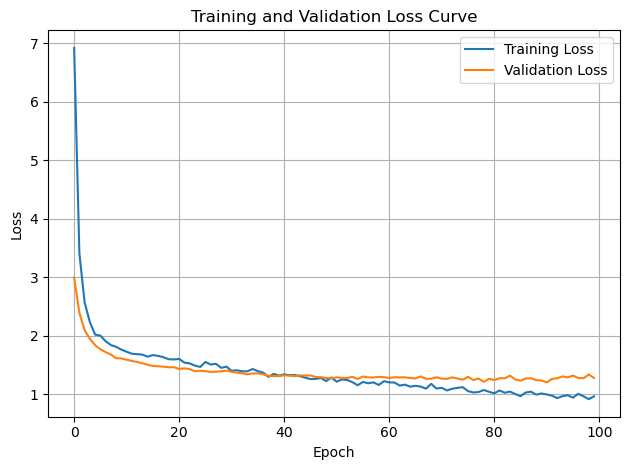

In [121]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
# Make predictions with uncertainty (in scaled space)
y_pred_mean, y_pred_std = predict(mcd_model, X_test_selected, samples=50)

# Inverse-transform predictions and std to original scale
#y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
#y_pred_std_orig = y_pred_std * y_scaler.scale_[0]  # std scales by the scaler's scale

# Calculate R² in original space
r2 = r2_score(y_test, y_pred_mean)
print("R² score:", r2)

R² score: 0.5556738229076448


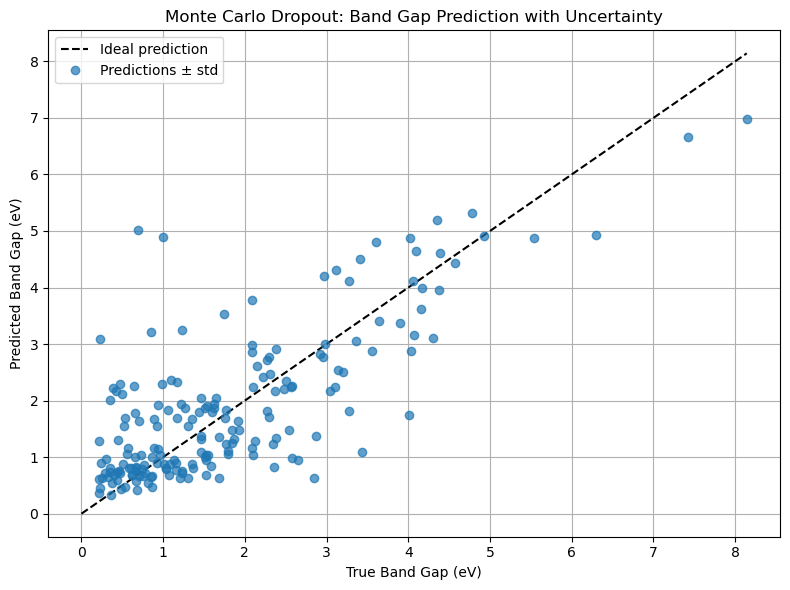

In [123]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred_mean, fmt='o', alpha=0.7, label='Predictions ± std')
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--', label='Ideal prediction')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Monte Carlo Dropout: Band Gap Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

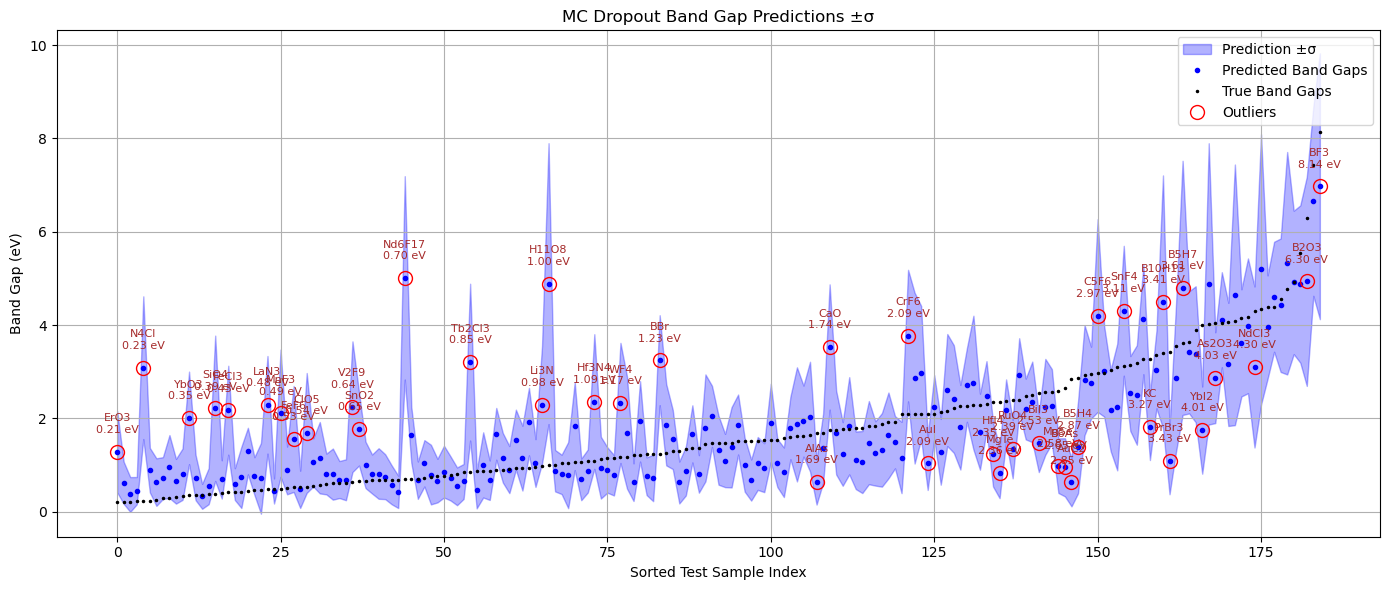

In [124]:

# Inverse-transform predictions and std to original scale
#y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
#y_pred_std_orig = y_pred_std * y_scaler.scale_[0]

# Convert predictions and uncertainties to arrays
y_true = np.array(y_test)
y_predicted = np.array(y_pred_mean)
y_std_dev = np.array(y_pred_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# Confidence interval (±σ)
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Optional: retrieve formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error and identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.0  # adjust threshold as needed
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers with formula and true band gap
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Log transformed data

In [153]:
def model_log(input_dim = 1, seed = 42):
    """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
    tf.random.set_seed(seed)
    """
    model = Sequential([
        Dense(256, input_shape=(input_dim, )),  
        Activation('relu'), 
        Dropout(0.3),
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(64), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(2)



    ])

    """
    
    

    model = Sequential([
    Dense(256, input_shape=(input_dim,)), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(256), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(128), BatchNormalization(), LeakyReLU(), Dropout(0.1),
    Dense(64), BatchNormalization(), LeakyReLU(), Dropout(0.1),
    Dense(2)
])
    
   
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model




In [154]:
# Step 1: Extract features and log-transform target
y = np.log1p(df_mp['band_gap'].values)  # log(1 + band_gap)
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Step 2: Train/test split
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

# Step 3: Scale and select features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_regression, k=100)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)


In [155]:
#print("Explained variance:", pca.explained_variance_ratio_)
#print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

In [156]:
input_dim = X_train_selected.shape[1]
mcd_model = model_log(input_dim=input_dim, seed=42)
mcd_model, history = train(
    X_train_selected, y_train,
    model=mcd_model,
    x_val=X_test_selected,
    y_val = y_test,
    epochs=100
)



/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - loss: 2.1621 - val_loss: 1.3472
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.3481 - val_loss: 1.2475
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1899 - val_loss: 1.1110
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0560 - val_loss: 0.9267
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9780 - val_loss: 0.8179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.8652 - val_loss: 0.7265
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7923 - val_loss: 0.6259
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7718 - val_loss: 0.6216
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6803 - val_loss: 0.5735
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6440 - val_loss: 0.5972
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6292 - val_loss: 0.5589
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.

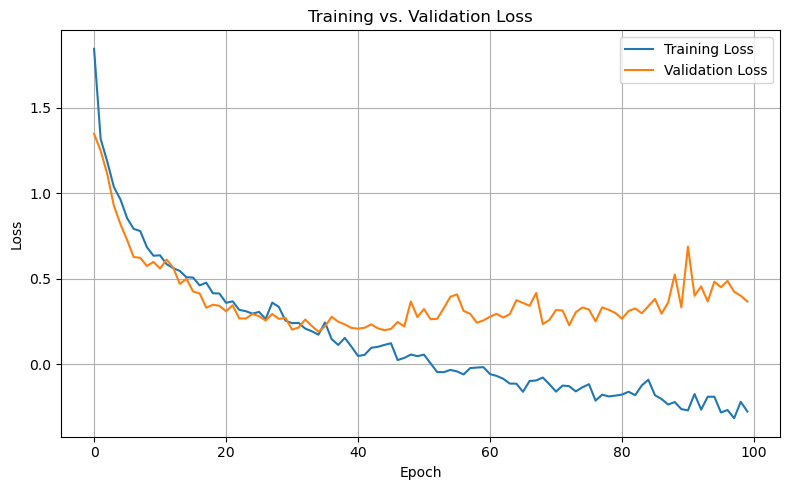

In [157]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [158]:
# Predict (log space)
y_pred_log, y_std_log = predict(mcd_model, X_test_selected, samples=50)

# Invert log1p transformation
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space
y_true = np.expm1(y_test)

# Calculate R² in original space
r2 = r2_score(y_true, y_pred)
print("R² score:", r2)


R² score: 0.5274320103427679


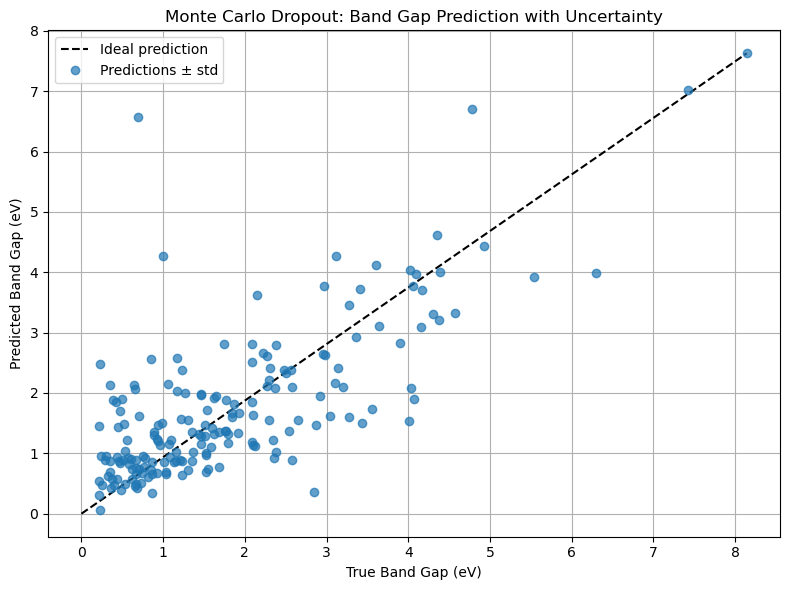

In [159]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_true, y_pred, fmt='o', alpha=0.7, label='Predictions ± std')
plt.plot([0, max(y_true)], [0, max(y_pred)], 'k--', label='Ideal prediction')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Monte Carlo Dropout: Band Gap Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

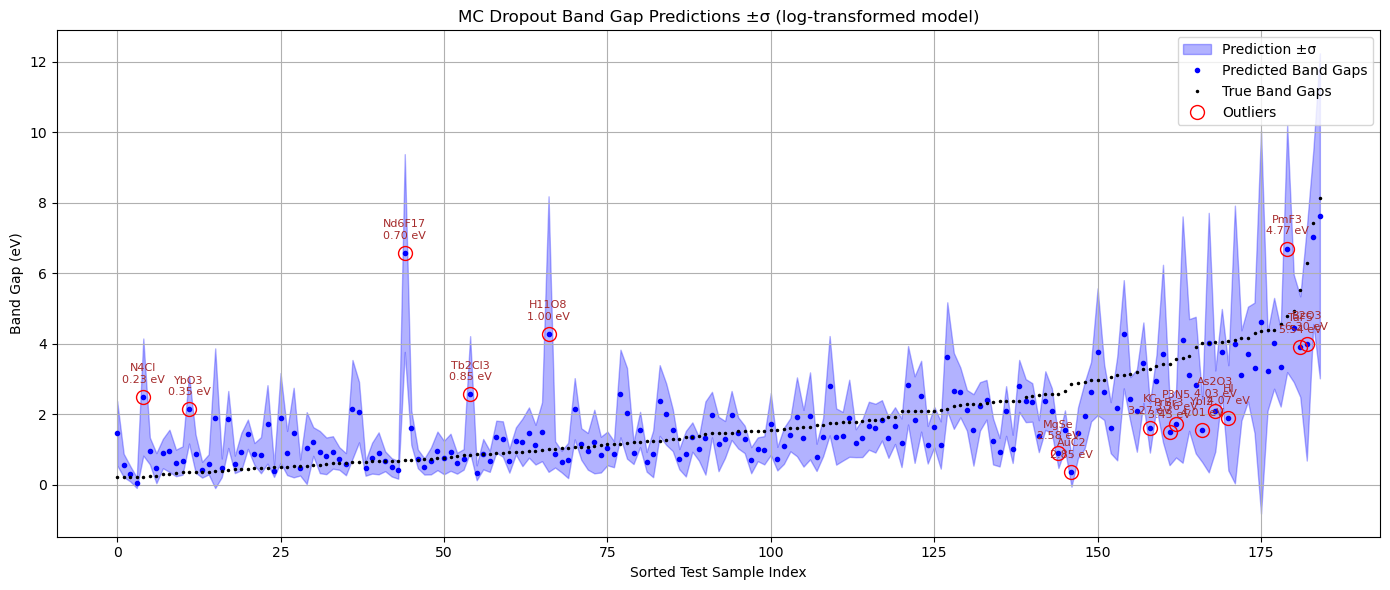

In [160]:
# Sort by true values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_std_sorted = y_std[sorted_idx]

# Confidence band
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Formulas for annotation
formulas_sorted = df_mp.loc[idx_test, "formula_pretty"].values[sorted_idx]

# Identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ (log-transformed model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


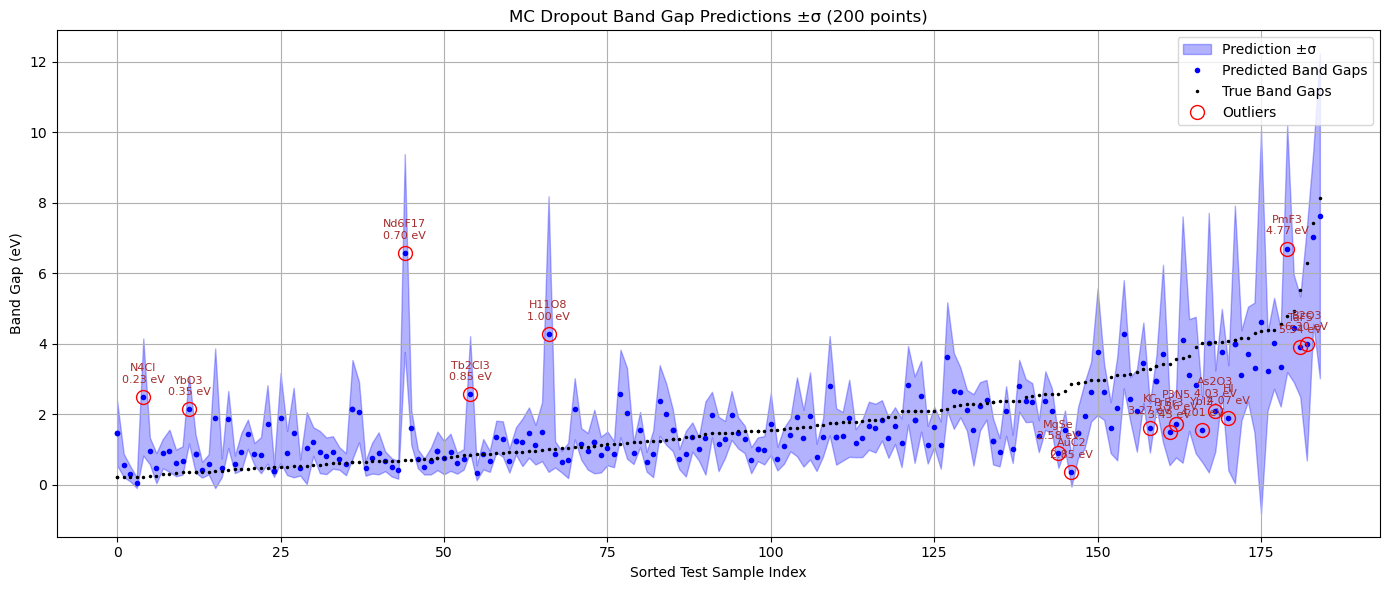

In [ ]:

# Choose 200 evenly spaced indices
n_points = 200
indices = np.linspace(0, len(y_true_sorted) - 1, n_points, dtype=int)

# Subset arrays
y_true_sub = y_true_sorted[indices]
y_pred_sub = y_pred_sorted[indices]
y_std_sub = y_std_sorted[indices]
lower_sub = lower[indices]
upper_sub = upper[indices]
formulas_sub = formulas_sorted[indices]
errors_sub = errors[indices]
outlier_mask_sub = outlier_mask[indices]
outlier_indices_sub = np.where(outlier_mask_sub)[0]

plt.figure(figsize=(14, 6))
plt.fill_between(indices, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(indices, y_pred_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(indices, y_true_sub, 'k.', markersize=3, label='True Band Gaps')
plt.plot(indices[outlier_indices_sub], y_pred_sub[outlier_mask_sub], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers (optional)
for i in outlier_indices_sub:
    plt.text(indices[i], y_pred_sub[i] + 0.4, f"{formulas_sub[i]}\n{y_true_sub[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ (200 points)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()